# Tutorial 3 - How to use ordinal preferences instead of cardinal

In this notebook, we are going to see how to implement an election with **ordinal preferences** in our model of voters with embeddings.

An election with **ordinal preferences** corresponds to an election in which each voter gives a **ranking** of the candidates instead of giving a different **score** to each candidate. It has been studied a lot and many rules exists for this model (*Plurality, Borda, k-approval, Condorcet, Instand Runoff, Maximin, etc.*).

In [1]:
import embedded_voting as ev
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(4242)

## Classic election

Let's **run an election** with **5 candidates** and **100 voters**. We obtain the following profile:

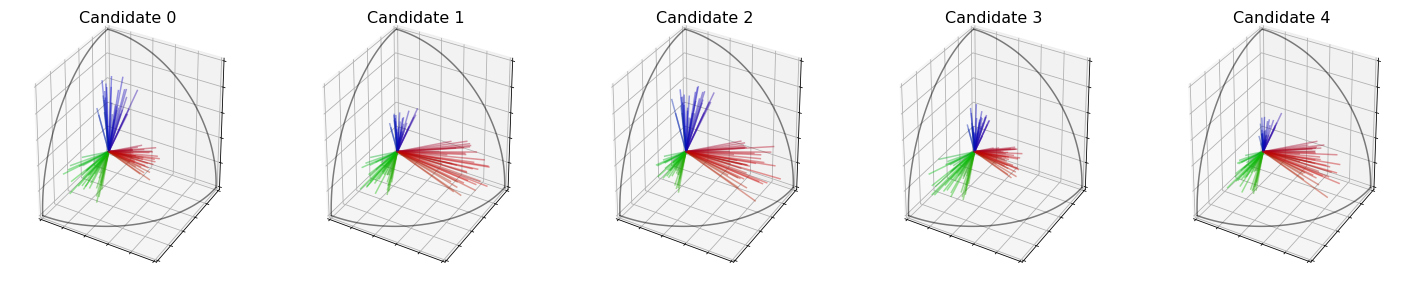

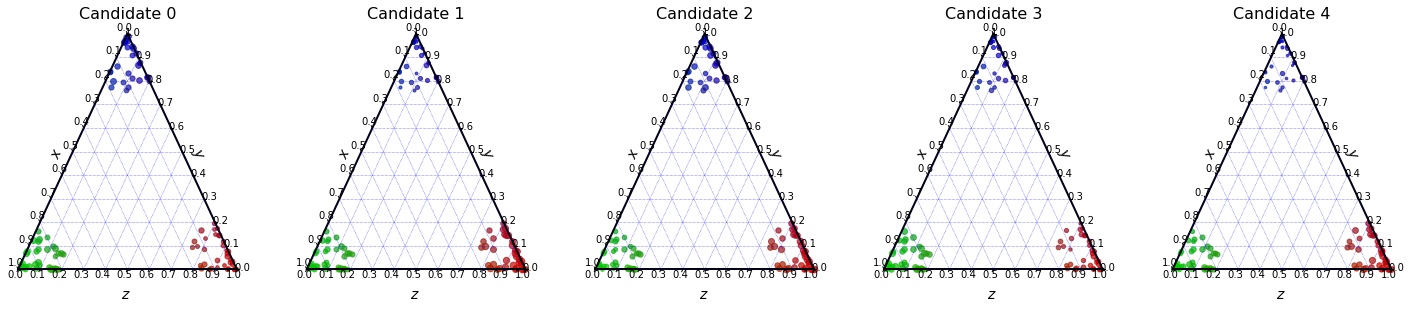

In [2]:
generator = ev.ProfileGenerator(100, 5, 3)
profile = generator(polarisation=0.4, coherence=0.7)
profile.plot_candidates("3D")
profile.plot_candidates("ternary")

If we use the rule **SVDNash**, we obtain the following ranking:

$$
c_2 > c_0 > c_1 > c_4 > c_3
$$



In [3]:
election = ev.SVDNash(profile)

We can also print **all the information** about the results of this rule:

In [4]:
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)

Scores :  [53.57308903173028, 53.26311862462435, 61.3690088934342, 41.23427485761405, 40.09434793473854]
Ranking :  [2, 0, 1, 3, 4]
Winner :  2
Welfare :  [0.6335584441585438, 0.6189885101084674, 1.0, 0.05358143780004999, 0.0]


## Positional scoring rules

Now, let's assume that instead of asking a **score vector** to each voter, we ask for a **ranking** of the candidate, and apply some rule with all the rankings.

A broad family of rule are **positional scoring rule**. A positional scoring rule is characterized by a vector $p = (p_1, \ldots, p_m)$ such that each voter $v_i$ gives $p_j$ points to the voters with rank $j$. The winner is the candidate with the maximum total score.

We can adapt this idea to scores between $0$ and $1$ by setting the score given by the voter $v_i$ to candidate $c_j$ as $\frac{p_k}{p_n}$ if the candidate $c_j$ is ranked at position $k$ in the ranking of $v_i$.

For instance, if the positional scoring rule is $(2, 1, 1, 1, 0)$, each voter gives a score of $1$ to her favorite candidate, $0$ to her least favorite candidate and $\frac{1}{2}$ to every other candidate:

In [5]:
ordinal_election = ev.PositionalRuleExtension([2, 1, 1, 1, 0], profile=profile, rule=ev.SVDNash())

If we plot the profile of the candidates now, it is very different than before:

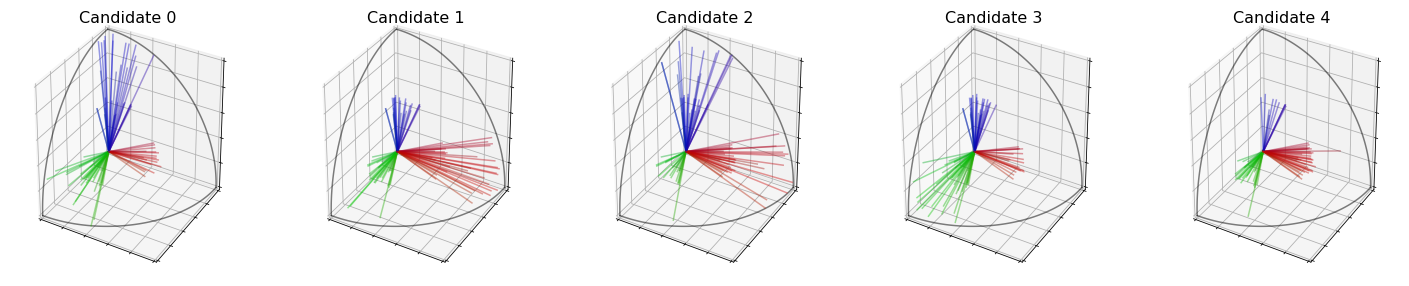

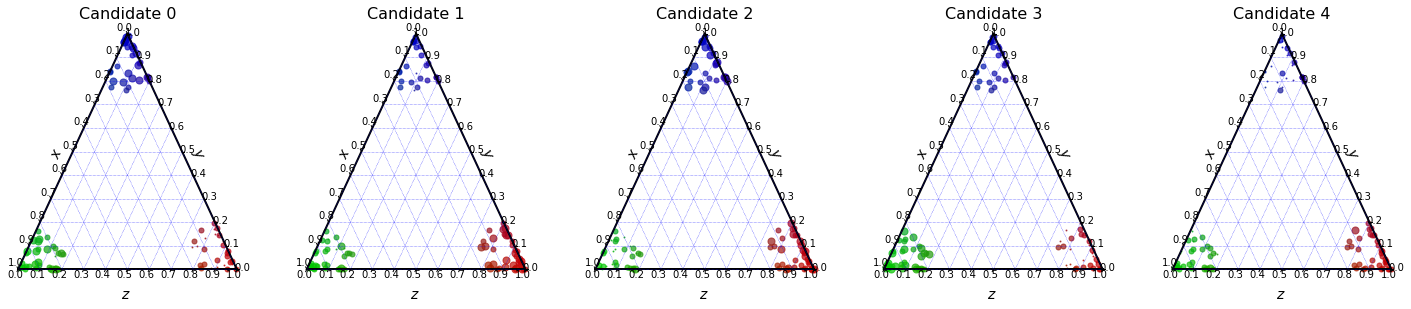

In [6]:
ordinal_election.plot_fake_profile("3D")
ordinal_election.plot_fake_profile("ternary")

The ranking obtained is different too. Indeed, the new ranking is 

$$
c_0 > c_1 > c_2 > c_3 > c_4
$$

and the new winner is $c_0$ instead of $c_2$.

In [7]:
print('Scores : ', ordinal_election.scores_)
print('Ranking : ', ordinal_election.ranking_)
print('Winner : ', ordinal_election.winner_)

Scores :  [52.52213475515042, 56.53724624778789, 56.16605097307537, 42.95305703555769, 28.438754829932286]
Ranking :  [1, 2, 0, 3, 4]
Winner :  1


### Plurality

**Plurality** is the positional scoring rule defined by the scoring vector $(1, 0, \ldots, 0)$. It is equivalent to saying that each voter only vote for his favorite candidate. We can see that in that case, almost nobody voted for candidate $c_4$:

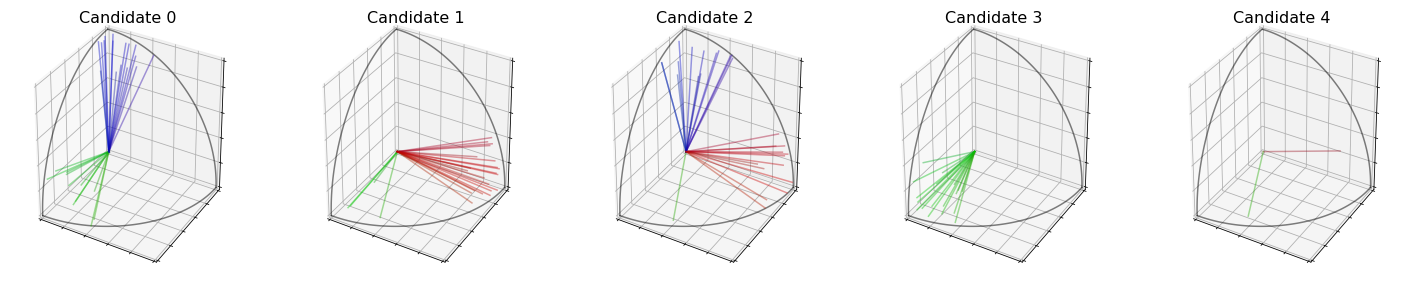

In [8]:
plurality_election = ev.PluralityExtension(profile=profile, rule=ev.SVDNash())
plurality_election.plot_fake_profile("3D")

The ranking obtained is different again, but the winner is still $c_2$ :

$$
c_2 > c_0 > c_1 > c_3 > c_3
$$



In [9]:
print('Scores : ', plurality_election.scores_)
print('Ranking : ', plurality_election.ranking_)
print('Winner : ', plurality_election.winner_)

Scores :  [8.035877254800573, 5.0400459816283965, 13.147451251082893, 1.105916113164726, 1.8367556403916578e-09]
Ranking :  [2, 0, 1, 3, 4]
Winner :  2


### Veto

The **Veto** is the opposite of Plurality. In this rule, every voter votes for all candidates **but one**. That is why it looks like every candidate is liked by a lot of voters:

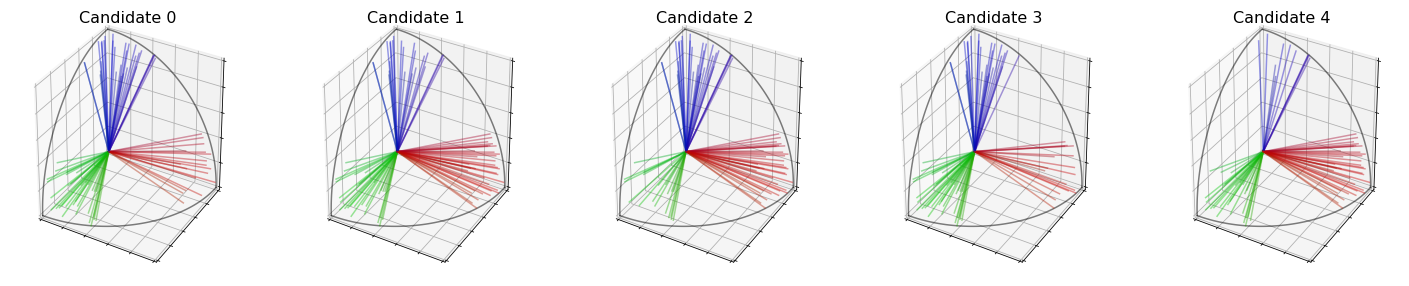

In [10]:
veto_election = ev.VetoExtension(profile=profile, rule=ev.SVDNash())
veto_election.plot_fake_profile("3D")

The ranking is different again, and the new winner is $c_1$:

$$
c_1 > c_0 > c_2 > c_4 > c_3
$$



In [11]:
print('Scores : ', veto_election.scores_)
print('Ranking : ', veto_election.ranking_)
print('Winner : ', veto_election.winner_)

Scores :  [101.84919372296065, 117.20949891492137, 108.07401371464373, 97.15101080477743, 78.12024860190259]
Ranking :  [1, 2, 0, 3, 4]
Winner :  1


### k-Approval

**K-approval** is the rule in between Plurality and Veto. Each voter votes for his **k** favorite candidates only. For instance, with $k=3$ :

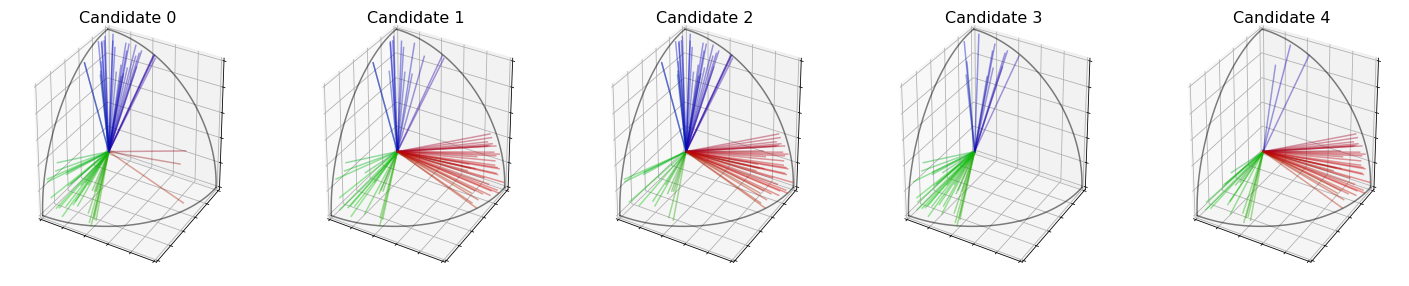

In [12]:
kapp_election = ev.KApprovalExtension(k=3, profile=profile, rule=ev.SVDNash())
kapp_election.plot_fake_profile("3D")

The ranking is different again, and the new winner is $c_1$:

$$
c_1 > c_2 > c_4 > c_0 > c_3
$$


In [13]:
print('Scores : ', kapp_election.scores_)
print('Ranking : ', kapp_election.ranking_)
print('Winner : ', kapp_election.winner_)

Scores :  [42.96374935925738, 76.72441319651273, 94.19290414647638, 13.666074249955665, 33.98967704683444]
Ranking :  [2, 1, 0, 4, 3]
Winner :  2


### Borda

**Borda** use the scoring vector $(m-1, m-2, \ldots, 1, 0)$ where $m$ is the total number of candidates.

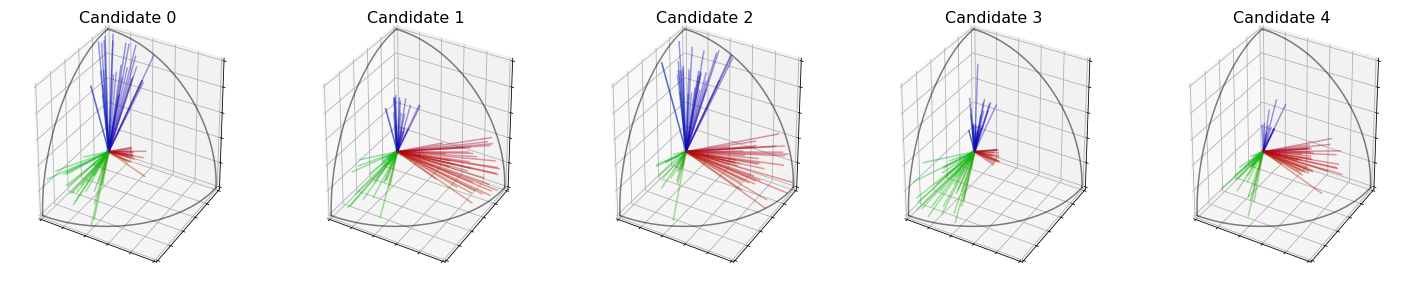

In [14]:
borda_election = ev.BordaExtension(profile=profile, rule=ev.SVDNash())
borda_election.plot_fake_profile("3D")

With this rule, we obtain **the same ranking** than in the original election:

In [15]:
print('Ranking : ', borda_election.ranking_)
print('Winner : ', borda_election.winner_)

Ranking :  [2, 1, 0, 3, 4]
Winner :  2


## Instant Runoff Voting (IRV)

Finally, we implemented **Instant Runoff Voting** which is not a positional scoring rule.

In this voting system, at each step, every voter votes for his favorite candidate, and the candidate with the lowest score **is eliminated**. Consequently, we perform $m-1$ elections before we can find the winner. The ranking obtained is the inverse of the order in which the candidates are eliminated.

In [16]:
irv_election = ev.InstantRunoffExtension(profile=profile, rule=ev.SVDNash())

In our case, we obtain the same winner $c_2$, but not the same ranking. The ranking obtained is the same than for **Plurality**.

In [17]:
print('Ranking : ', irv_election.ranking_)
print('Winner : ', irv_election.winner_)

Ranking :  [2, 0, 1, 3, 4]
Winner :  2


## Summary

Here is a little **summary** of the rankings and the winners obtained with the different extensions.

As you can see, the ranking can change a lot if we use an ordinal extension of the voting rule:

| Extension | Ranking   | Winner   |
|-----------|-----------|----------|
| None      |$$c_2 > c_0 > c_1 > c_4 > c_3$$ | $c_2$ |
| $$(2,1,1,1,0)$$   |$$c_0 > c_1 > c_2 > c_3 > c_4$$ | $c_0$ |
| Plurality      |$$c_2 > c_0 > c_1 > c_3 > c_4$$ | $c_2$ |
| Veto      |$$c_1 > c_0 > c_2 > c_4 > c_3$$ | $c_1$ |
| 3-approval      |$$c_1 > c_2 > c_4 > c_0 > c_3$$ | $c_1$ |
| Borda      |$$c_2 > c_0 > c_1 > c_4 > c_3$$ | $c_2$ |
| IRV     |$$c_2 > c_0 > c_1 > c_3 > c_4$$ | $c_2$ |